import the modules and get dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
import cv2
import data
from PIL import Image
import dlib
import data_process
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


In [2]:
x,y, a = data_process.process_data('dataset.csv', "CNN")

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
val_data = (X_test,y_test)

import keras for the model training and layers

In [3]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D,ZeroPadding2D, MaxPool2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

create the model with it's layers:

In [4]:
input_shape=(48, 48, 1)
num_classes = 4

model_1 = Sequential()
model_1.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (5, 5), strides = (1,1)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 32)        25632     
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0

import data generator

In [5]:
from keras.preprocessing.image import ImageDataGenerator


compile the model:

In [6]:
%%time
# data generator Generate batches of tensor image data with real-time data augmentation
data_generator = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        horizontal_flip=True)
batch_size = 32
opt = RMSprop(lr=0.0005, decay=1e-6)

model_1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_1 = model_1.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
12/12 [==============================] - 1s 107ms/step - loss: 1.7143 - accuracy: 0.3307 - val_loss: 1.3078 - val_accuracy: 0.4375
Epoch 2/20
12/12 [==============================] - 1s 97ms/step - loss: 1.2653 - accuracy: 0.4323 - val_loss: 1.2495 - val_accuracy: 0.4688
Epoch 3/20
12/12 [==============================] - 1s 97ms/step - loss: 1.1952 - accuracy: 0.4609 - val_loss: 1.2156 - val_accuracy: 0.4896
Epoch 4/20
12/12 [==============================] - 1s 97ms/step - loss: 1.1425 - accuracy: 0.4661 - val_loss: 1.1115 - val_accuracy: 0.5104
Epoch 5/20
12/12 [==============================] - 1s 95ms/step - loss: 1.0525 - accuracy: 0.5391 - val_loss: 0.9700 - val_accuracy: 0.5729
Epoch 6/20
12/12 [==============================] - 1s 96ms/step - loss: 0.9286 - accuracy: 0.6276 - val_loss: 0.9184 - val_accuracy: 0.5729
Epoch 7/20
12/12 [==============================] - 1s 95ms/step - loss: 0.83

Plot

3/3 [==============================] - 0s 9ms/step - loss: 0.4586 - accuracy: 0.8125


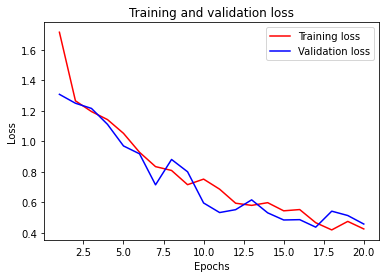

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
score = model_1.evaluate(X_test, y_test, verbose=1)
history_dict=hist_model_1.history
history_dict.keys()

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, train_loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

do the same with dataset2.csv

In [8]:
x2, y2, a2= data_process.process_data('dataset2.csv', "CNN")
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
val_data2 = (X_test2,y_test2)


model:

In [9]:
input_shape=(48, 48, 1)
num_classes = 4

model_2 = Sequential()

model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        25632     
_________________________________________________________________
activation_5 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)            

data generator

In [10]:
%%time
data_generator2 = ImageDataGenerator(
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        horizontal_flip=True)
batch_size = 32
opt2 = RMSprop(lr=0.0005, decay=1e-6)

model_2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_2 = model_2.fit_generator(data_generator2.flow(X_train2, y_train2,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data2)

Epoch 1/20
12/12 [==============================] - 1s 110ms/step - loss: 1.7351 - accuracy: 0.3125 - val_loss: 1.3741 - val_accuracy: 0.4375
Epoch 2/20
12/12 [==============================] - 1s 99ms/step - loss: 1.3422 - accuracy: 0.3776 - val_loss: 1.2248 - val_accuracy: 0.5000
Epoch 3/20
12/12 [==============================] - 1s 100ms/step - loss: 1.2270 - accuracy: 0.4505 - val_loss: 1.1448 - val_accuracy: 0.5312
Epoch 4/20
12/12 [==============================] - 1s 98ms/step - loss: 1.1830 - accuracy: 0.4922 - val_loss: 1.1196 - val_accuracy: 0.5521
Epoch 5/20
12/12 [==============================] - 1s 97ms/step - loss: 1.1097 - accuracy: 0.5495 - val_loss: 0.9741 - val_accuracy: 0.6250
Epoch 6/20
12/12 [==============================] - 1s 98ms/step - loss: 1.0468 - accuracy: 0.5521 - val_loss: 0.8250 - val_accuracy: 0.7083
Epoch 7/20
12/12 [==============================] - 1s 98ms/step - loss: 0.9552 - accuracy: 0.5938 - val_loss: 0.7163 - val_accuracy: 0.7396
Epoch 8/20


plot

3/3 [==============================] - 0s 10ms/step - loss: 0.4351 - accuracy: 0.7812


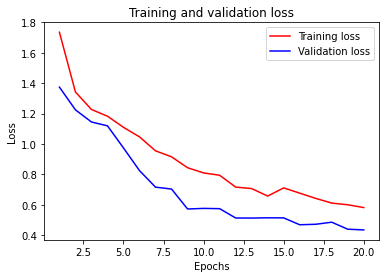

In [11]:
score2 = model_2.evaluate(X_test2, y_test2, verbose=1)
history_dict2=hist_model_2.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

compare classification metrics


In [12]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

metrics = list()
cm = dict()
y_pred = model_1.predict(X_test)
y_pred_class = model_1.predict_classes(X_test, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2 = model_2.predict(X_test2)
y_pred_class2 = model_2.predict_classes(X_test2, verbose=0)
rounded_labels2 = np.argmax(y_test2, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2, y_pred2)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'auc':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


,model1,model2
precision,0.800347,0.764686
recall,0.812500,0.781250
fscore,0.800083,0.743241
accuracy,0.812500,0.781250
auc,0.953304,0.968493


In [13]:

def get_unique_N(iterable):
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e

k = get_unique_N(a)
print(list(k))

['happy', 'sadness', 'contempt', 'anger']


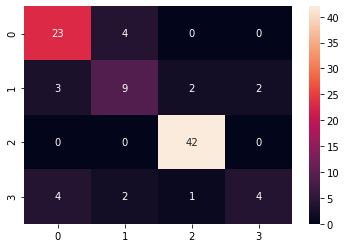

In [14]:
ax = sns.heatmap(cm, annot=True, fmt='d')

In [15]:
k2 = get_unique_N(a2)
print(list(k2))

['happy', 'sadness', 'anger', 'contempt']


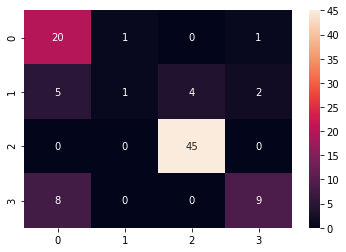

In [16]:
ax2 = sns.heatmap(cm2, annot=True, fmt='d')


In [17]:
input_shape=(48, 48, 1)
num_classes = 4

model_3 = Sequential()

model_3.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_3.add(Activation('relu'))

model_3.add(Conv2D(32, (5, 5), strides = (1,1)))
model_3.add(Activation('relu'))

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        25632     
_________________________________________________________________
activation_9 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15488)            

In [18]:
%%time
model_3.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_3 = model_3.fit(X_train, y_train,batch_size, epochs=20, verbose=1,validation_data =val_data)

Epoch 1/20
12/12 [==============================] - 1s 103ms/step - loss: 1.4552 - accuracy: 0.4401 - val_loss: 1.1613 - val_accuracy: 0.5000
Epoch 2/20
12/12 [==============================] - 1s 95ms/step - loss: 0.8724 - accuracy: 0.6432 - val_loss: 0.7401 - val_accuracy: 0.6771
Epoch 3/20
12/12 [==============================] - 1s 96ms/step - loss: 0.4616 - accuracy: 0.8203 - val_loss: 0.5562 - val_accuracy: 0.7604
Epoch 4/20
12/12 [==============================] - 1s 96ms/step - loss: 0.2520 - accuracy: 0.9089 - val_loss: 0.4713 - val_accuracy: 0.8021
Epoch 5/20
12/12 [==============================] - 1s 98ms/step - loss: 0.1801 - accuracy: 0.9375 - val_loss: 0.4036 - val_accuracy: 0.8646
Epoch 6/20
12/12 [==============================] - 1s 98ms/step - loss: 0.1244 - accuracy: 0.9635 - val_loss: 0.4428 - val_accuracy: 0.8646
Epoch 7/20
12/12 [==============================] - 1s 97ms/step - loss: 0.0940 - accuracy: 0.9635 - val_loss: 0.3448 - val_accuracy: 0.9062
Epoch 8/20
1

3/3 [==============================] - 0s 11ms/step - loss: 0.4110 - accuracy: 0.9375


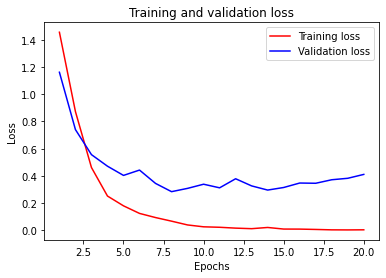

In [19]:
score2 = model_3.evaluate(X_test, y_test, verbose=1)
history_dict2=hist_model_3.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
%%time
model = Sequential()
model.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Wall time: 79 ms


In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_3 = model.fit(X_train2, y_train2,batch_size, epochs=20, verbose=1,validation_data =val_data2)

Epoch 1/20
12/12 [==============================] - 1s 111ms/step - loss: 1.2522 - accuracy: 0.4271 - val_loss: 1.1995 - val_accuracy: 0.5312
Epoch 2/20
12/12 [==============================] - 1s 103ms/step - loss: 1.0742 - accuracy: 0.5573 - val_loss: 0.7896 - val_accuracy: 0.6667
Epoch 3/20
12/12 [==============================] - 1s 102ms/step - loss: 0.7610 - accuracy: 0.6719 - val_loss: 0.5363 - val_accuracy: 0.7188
Epoch 4/20
12/12 [==============================] - 1s 99ms/step - loss: 0.5072 - accuracy: 0.7865 - val_loss: 0.4208 - val_accuracy: 0.7812
Epoch 5/20
12/12 [==============================] - 1s 102ms/step - loss: 0.4381 - accuracy: 0.8073 - val_loss: 0.2996 - val_accuracy: 0.8958
Epoch 6/20
12/12 [==============================] - 1s 102ms/step - loss: 0.3836 - accuracy: 0.8255 - val_loss: 0.2949 - val_accuracy: 0.8958
Epoch 7/20
12/12 [==============================] - 1s 102ms/step - loss: 0.2849 - accuracy: 0.9010 - val_loss: 0.2026 - val_accuracy: 0.8958
Epoch 8

3/3 [==============================] - 0s 10ms/step - loss: 0.0120 - accuracy: 1.0000


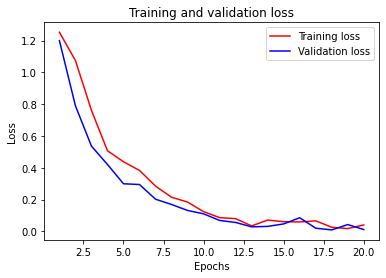

In [22]:
score2 = model.evaluate(X_test2, y_test2, verbose=1)
history_dict2=hist_model_3.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
metrics = list()
cm = dict()
y_pred = model_3.predict(X_test)
y_pred_class = model_3.predict_classes(X_test, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2 = model.predict(X_test2)
y_pred_class2 = model.predict_classes(X_test2, verbose=0)
rounded_labels2 = np.argmax(y_test2, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2, y_pred2)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'auc':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics

,model1,model2
precision,0.939872,1.0
recall,0.937500,1.0
fscore,0.937567,1.0
accuracy,0.937500,1.0
auc,0.984972,1.0


In [24]:
%%time

model.predict_classes(X_test, verbose=0)
# model.compile(optimizer='adam', loss='categorical_crossentropy',
#               metrics=['accuracy'])

# hist_model_3 = model.fit(X_train, y_train,batch_size, epochs=20, verbose=1,validation_data =val_data)

Wall time: 66 ms


array([1, 0, 2, 3, 1, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 3, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 0, 3, 2, 2, 2, 2, 3, 0, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 3,
       2, 3, 2, 3, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 1, 3, 2, 3, 2,
       0, 2, 0, 1, 2, 1, 2, 1, 2, 3, 0, 1, 1, 1, 2, 2, 2, 3, 2, 0, 1, 0,
       1, 0, 3, 2, 1, 3, 3, 3], dtype=int64)

In [25]:
%%time
model = Sequential()
model.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Wall time: 89 ms


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_3 = model.fit(X_train, y_train,batch_size, epochs=20, verbose=1,validation_data =val_data)

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.3180 - accuracy: 0.4010

In [ ]:
score2 = model.evaluate(X_test, y_test, verbose=1)
history_dict2=hist_model_3.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))


model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))


model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_3 = model_2.fit(X_train2, y_train2,batch_size, epochs=20, verbose=1,validation_data =val_data2)

In [ ]:
score2 = model_2.evaluate(X_test, y_test, verbose=1)
history_dict2=hist_model_3.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
metrics = list()
cm = dict()
y_pred = model.predict(X_test)
y_pred_class = model.predict_classes(X_test, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2 = model_2.predict(X_test2)
y_pred_class2 = model_2.predict_classes(X_test2, verbose=0)
rounded_labels2 = np.argmax(y_test2, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2, y_pred2)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'auc':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(32, (5, 5), strides = (1,1)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_1 = model.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data)

In [ ]:
score2 = model.evaluate(X_test, y_test, verbose=1)
history_dict2=hist_model_1.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_2 = Sequential()
model_2.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', input_shape=input_shape))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))


model_2.add(Conv2D(32, (5, 5), strides = (1,1)))
model_2.add(Activation('relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))


model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

hist_model_2 = model_2.fit_generator(data_generator2.flow(X_train2, y_train2,
                                            batch_size),
                        epochs=20, verbose=1,validation_data =val_data2)

In [ ]:
score2 = model_2.evaluate(X_test, y_test, verbose=1)
history_dict2=hist_model_2.history
history_dict2.keys()

train_loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']

epochs2 = range(1, len(history_dict2['accuracy']) + 1)

plt.plot(epochs2, train_loss_values2, 'r', label='Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
metrics = list()
cm = dict()
y_pred = model.predict(X_test)
y_pred_class = model.predict_classes(X_test, verbose=0)
rounded_labels = np.argmax(y_test, axis=1)

precision, recall, fscore, _ = score(rounded_labels, y_pred_class, average='weighted')
accuracy = accuracy_score(rounded_labels, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'auc':auc}, name="model1"))
cm = confusion_matrix(rounded_labels,y_pred_class)

metrics2 = list()
cm2 = dict()
y_pred2 = model_2.predict(X_test2)
y_pred_class2 = model_2.predict_classes(X_test2, verbose=0)
rounded_labels2 = np.argmax(y_test2, axis=1)

precision2, recall2, fscore2, _ = score(rounded_labels2, y_pred_class2, average='weighted')
accuracy2 = accuracy_score(rounded_labels2, y_pred_class2)
auc2 = roc_auc_score(y_test2, y_pred2)
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2, 'auc':auc2}, name="model2"))
cm2 = confusion_matrix(rounded_labels2,y_pred_class2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics